# HuBMAP-Intro to Segmentation using Tensorflow: My approach
* Hi everyone, this is my first segmentation based problem and it has been an excellent learning oppportunity so far. I referred some public kernels and discussions that helped me to get started with this competition.
* If you guys like this approach then do consider upvoting this notebook and feel free to leave a comment if you have any better ideas. 

# Installing Prerequisites

In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 578.8 kB/s eta 0:00:00


# Imports

In [2]:
import numpy as np
import pandas as pd
import math
from typing import Union, List, Tuple, Dict
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
plt.style.use('Solarize_Light2')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import gc
gc.enable()
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

In [3]:
cfg = {
    'train_df': '../input/hubmap-organ-segmentation/train.csv',
    'train_img': '../input/hubmap-organ-segmentation/train_images/',
    'train_annot': '../input/hubmap-organ-segmentation/train_annotations/',
    'slices': 4, #Batch size = slices ** 2
    'epochs': 3,
    'img_shape': 2304,
    'lr': 1e-03
}

unet_cfg = {
    'backbone_name': 'resnet50',
    'input_shape': (int(cfg['img_shape'] / cfg['slices']), int(cfg['img_shape'] / cfg['slices']), 3), #the H and W of the image should be divisible by 32
    'classes': 1,
    'activation': 'sigmoid',
    'weights': None, #optional path to weigths file
    'encoder_weights': 'imagenet',#'imagenet'
    'encoder_freeze': True,
    'encoder_features': 'default',
    'decoder_block_type': 'upsampling',
    'decoder_filters': (256, 128, 64, 32, 16),
    'decoder_use_batchnorm': True
}

In [4]:
df = pd.read_csv(cfg['train_df'])
df['paths'] = [f'../input/hubmap-organ-segmentation/train_images/{str(i)}.tiff' for i in tqdm(df['id'])]
df.shape

  0%|          | 0/351 [00:00<?, ?it/s]

(351, 11)

In [5]:
print(df.img_height.unique())
print(df.img_width.unique())
df.head()

[3000 2867 2654 2727 2680 2539 2631 2790 2942 2308 2764 2783 2869 2760
 2630 2511 2416 2593 2675 3070]
[3000 2867 2654 2727 2680 2539 2631 2790 2942 2308 2764 2783 2869 2760
 2630 2511 2416 2593 2675 3070]


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../input/hubmap-organ-segmentation/train_image...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../input/hubmap-organ-segmentation/train_image...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../input/hubmap-organ-segmentation/train_image...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../input/hubmap-organ-segmentation/train_image...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../input/hubmap-organ-segmentation/train_image...


In [6]:
train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=20)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
train_df.head()
#del df; gc.collect()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
0,24100,kidney,HPA,3000,3000,0.4,4,1392950 5 1395945 19 1398942 26 1401938 31 140...,68.0,Female,../input/hubmap-organ-segmentation/train_image...
1,5086,lung,HPA,3000,3000,0.4,4,1510934 32 1513930 36 1516928 38 1519926 40 15...,65.0,Male,../input/hubmap-organ-segmentation/train_image...
2,1229,prostate,HPA,2654,2654,0.4,4,229957 31 232610 33 235217 84 237869 87 240521...,37.0,Male,../input/hubmap-organ-segmentation/train_image...
3,15787,kidney,HPA,3000,3000,0.4,4,1776723 16 1779722 17 1782722 17 1785717 23 17...,68.0,Female,../input/hubmap-organ-segmentation/train_image...
4,30414,prostate,HPA,3000,3000,0.4,4,1740909 27 1743907 31 1746899 40 1749897 42 17...,55.0,Male,../input/hubmap-organ-segmentation/train_image...


# Helper Functions:
#### These are some functions that will be used further in this notebook.

In [7]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def generate_tile(img, mask, slices=4, display=True):
    '''
    Generates tiles of images and its corresponding mask
    Returns: Two lists, image tiles and mask tiles of length slices**2 
    '''
    if img.shape[0] == mask.shape[0] and img.shape[1] == mask.shape[1]:
        factor = int(img.shape[0] / slices)
        #print(f'Size of each frame/tile: {factor, factor}')
        img_tiles = []
        mask_tiles = []
        temp_img = None
        temp_tile = None
        for x in range(slices):
            for y in range(slices):
                temp_img = img[factor*x : factor*(x+1), factor*y: factor*(y+1), ...]
                img_tiles.append(temp_img)
                temp_mask = mask[factor*x:factor*(x+1), factor*y: factor*(y+1)]
                mask_tiles.append(temp_mask)
                del temp_img; del temp_mask; gc.collect()
                
        if display:
            fig, ax = plt.subplots(nrows=slices, ncols=slices, figsize=(10,10))
            for i in range(slices):
                for j in range(slices):
                    ax[i, j].set_axis_off()
                    ax[i, j].imshow(img_tiles[slices*i+j])
                    ax[i, j].imshow(mask_tiles[slices*i+j], cmap='coolwarm', alpha=0.5)
            fig.tight_layout()
        return img_tiles, mask_tiles
    
    else:
        print('Shapes do not match.')
        return None

    
    
def img_transpose(idx: int):
    '''
    Helps visualizing image and its corresponding transpose image
    '''
    idx = os.listdir(cfg['train_img'])[idx]
    img = Image.open(f'../input/hubmap-organ-segmentation/train_images/{idx}')
    img = np.array(img)

    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]

    R, G, B = R.T, G.T, B.T
    R, G, B = R.reshape(3000, 3000,1), G.reshape(3000, 3000,1), B.reshape(3000, 3000,1)
    new_img = np.dstack((R, G, B))

    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title("Transposed")
    

    
def display_img(idx: int):
    '''
    Displays image along with its mask
    '''
    idx = os.listdir(cfg['train_img'])[idx]
    sample = idx[:-5]
    row = train_df.loc[train_df['id'] == int(sample)]
    h, w = row['img_height'].iloc[-1], row['img_width'].iloc[-1]
    img = Image.open(row['paths'].iloc[-1])
    img = np.array(img)
    sample = row['rle'].iloc[-1]
    mask = rle2mask(sample, shape=(int(h), int(w)))
    print(f'mask shape: {mask.shape}, image shape: {img.shape}')
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(mask, cmap='coolwarm', alpha=0.5)
    return img, mask


def tiles2img(img_tiles: list, mask_tiles: list, display = True):
    '''
    Converts tiles of images and masks to one array
    '''
    slices = int(math.sqrt(len(img_tiles)))
    img = []
    mask = []
    temp_img = None
    temp_mask = None
    for i in tqdm(range(slices)):
        temp_img = img_tiles[slices*i: slices*(i+1)]
        temp_img = np.hstack([i for i in temp_img])
        temp_mask = mask_tiles[slices*i: slices*(i+1)]
        temp_mask = np.hstack([i for i in temp_mask])
        img.append(temp_img)
        mask.append(temp_mask)
        del temp_img, temp_mask; gc.collect()
    img = np.vstack([i for i in img])
    mask = np.vstack([i for i in mask])
    if display:
        plt.imshow(img)
        plt.imshow(mask, cmap='coolwarm', alpha=0.5)
        plt.axis('off')
        print(img.shape)
        print(mask.shape)
    return img, mask

## Exploratory Data Analysis

In [8]:
df.describe()

,id,img_height,img_width,pixel_size,tissue_thickness,age
count,351.000000,351.000000,351.000000,3.510000e+02,351.0,351.000000
mean,16662.914530,2978.364672,2978.364672,4.000000e-01,4.0,60.364672
std,9863.945557,90.962085,90.962085,1.111808e-16,0.0,16.013327
min,62.000000,2308.000000,2308.000000,4.000000e-01,4.0,21.000000
25%,8229.000000,3000.000000,3000.000000,4.000000e-01,4.0,55.000000
50%,16609.000000,3000.000000,3000.000000,4.000000e-01,4.0,60.000000
75%,25630.500000,3000.000000,3000.000000,4.000000e-01,4.0,73.000000
max,32741.000000,3070.000000,3070.000000,4.000000e-01,4.0,84.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
 10  paths             351 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 30.3+ KB


In [10]:
H = df.img_height.value_counts().to_dict()
W = df.img_width.value_counts().to_dict()
print(H)
print(W)

{3000: 326, 2631: 2, 2416: 2, 2942: 2, 2790: 2, 2764: 2, 2654: 2, 2539: 1, 2680: 1, 2727: 1, 2308: 1, 2867: 1, 2783: 1, 2869: 1, 2760: 1, 2630: 1, 2511: 1, 2593: 1, 2675: 1, 3070: 1}
{3000: 326, 2631: 2, 2416: 2, 2942: 2, 2790: 2, 2764: 2, 2654: 2, 2539: 1, 2680: 1, 2727: 1, 2308: 1, 2867: 1, 2783: 1, 2869: 1, 2760: 1, 2630: 1, 2511: 1, 2593: 1, 2675: 1, 3070: 1}


mask shape: (3000, 3000), image shape: (3000, 3000, 3)


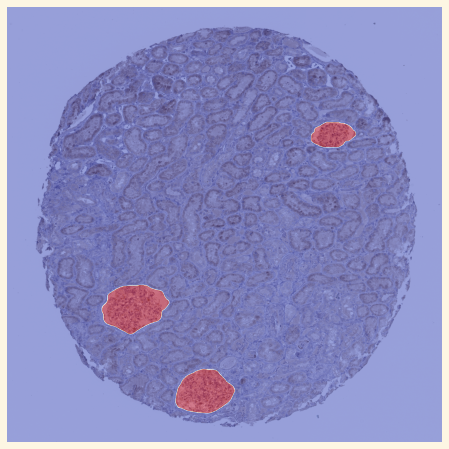

In [11]:
img, mask = display_img(65)

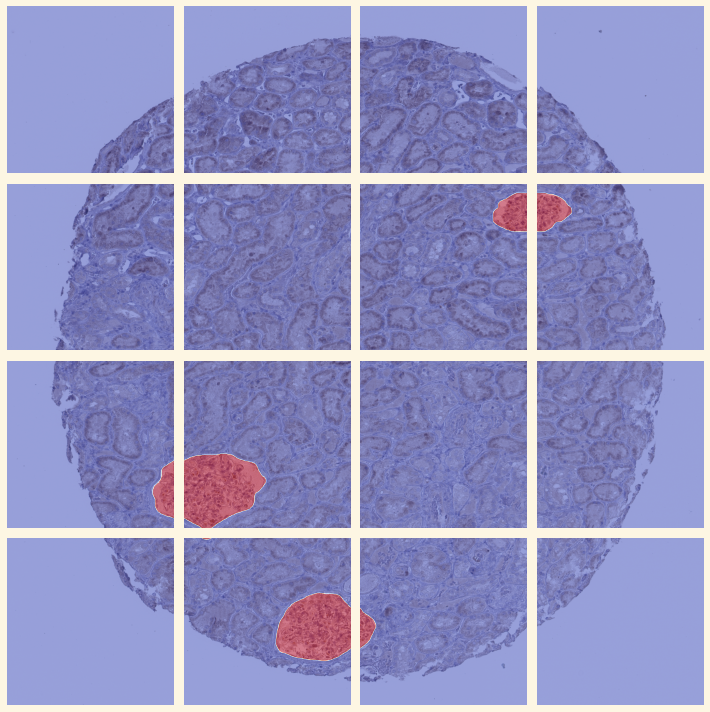

In [12]:
img_tiles, mask_tiles = generate_tile(img, mask)

  0%|          | 0/4 [00:00<?, ?it/s]

(3000, 3000, 3)
(3000, 3000)


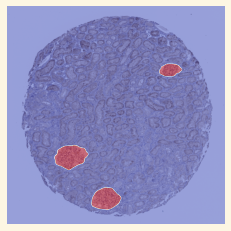

In [13]:
img, mask = tiles2img(img_tiles, mask_tiles)

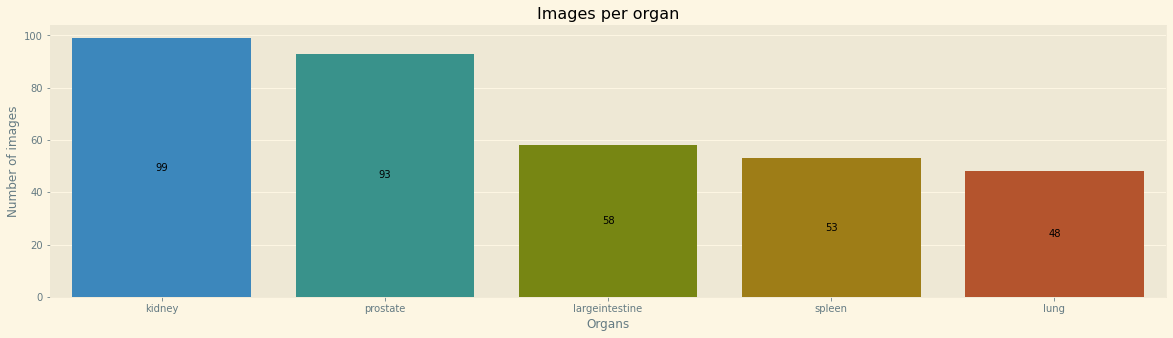

In [14]:
vals = df.organ.value_counts().to_dict()
plt.figure(figsize=(20,5))
ax = sns.barplot(x = list(vals.keys()), y = [i for i in vals.values()])
ax.bar_label(ax.containers[0], label_type='center')
plt.title("Images per organ")
plt.ylabel("Number of images")
plt.xlabel("Organs")
plt.show()

# Tensorflow Data Pipeline

In [15]:
class DataSetGen(Sequence):
    def __init__(self, df, img_dir=cfg['train_img'], img_shape=cfg['img_shape'], slices=cfg['slices'], shuffle=True):
        self.df = df
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.slices = slices
        self.shuffle = shuffle
        if self.shuffle:
            self.on_epoch_end()
        
    def on_epoch_end(self):
        '''
        Called after the end of every epoch, here it shuffles the dataframe
        '''
        gc.collect()
        self.df = self.df.sample(frac=1)
        self.df.reset_index(inplace=True)
        return self.df.drop('index', inplace=True, axis=1)
    
    def __len__(self):
        '''
        Denotes the number of batches per epoch
        '''
        return len(self.df)
    
    def __getitem__(self, idx):
        '''
        Generates one batch of data
        '''
        row = self.df.loc[idx]
        img_id = str(row['id']) + '.tiff'
        img_path = os.path.join(self.img_dir, img_id)
        rle = row['rle']
        del row; del img_id; gc.collect()
        return self.__get_data(img_path, rle)
    
    def __get_data(self, img_path, rle):
        '''
        Reads image and masks, generates tiles
        '''
        img_batch = None
        masks_batch = None
        img = Image.open(img_path)
        img = np.array(img)
        mask = rle2mask(rle, (img.shape[0], img.shape[1]))
        img = cv2.resize(img, (self.img_shape, self.img_shape))
        img = img / 255.0
        mask = cv2.resize(mask, (self.img_shape, self.img_shape)).reshape((self.img_shape, self.img_shape, 1))
        img_batch, masks_batch = generate_tile(img, mask, self.slices, display=False)
        del mask; del img; gc.collect()
        return np.asarray(img_batch).astype(np.float32), np.asarray(masks_batch).astype(np.float32)

In [16]:
train_ds = DataSetGen(train_df)
valid_ds = DataSetGen(valid_df)

# Training Model

In [17]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
unet = Unet(**unet_cfg)
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    unet
])
model.build(input_shape=(None, unet_cfg['input_shape'][0], unet_cfg['input_shape'][1], unet_cfg['input_shape'][2]))
model.summary()

Segmentation Models: using `keras` framework.
94601216/94592056 [==============================] - 14s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast (RandomContr (None, 576, 576, 3)       0         
_________________________________________________________________
model_1 (Functional)         (None, 576, 576, 1)       32561114  
Total params: 32,561,114
Trainable params: 9,058,644
Non-trainable params: 23,502,470
_________________________________________________________________


# Metrics and loss functions

In [18]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

# Model compilation and training

In [19]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=bce_dice_loss, metrics = [dice_coef,iou_coef])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_dice_coef',
    verbose=0,
    save_best_only=True,
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_dice_coef',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

es = tf.keras.callbacks.EarlyStopping(
    patience=3,
    min_delta=0,
    monitor='val_dice_coef',
    restore_best_weights=True,
    verbose=0,
    mode='min',
    baseline=None
)

history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    workers=4,
                    epochs = cfg['epochs'],
                    callbacks=[es,reduce_lr,checkpoint],
                    verbose=1
                   )

Epoch 1/3
280/280 [==============================] - 1513s 5s/step - loss: 0.6884 - dice_coef: 0.2112 - iou_coef: 0.0819 - val_loss: 0.9983 - val_dice_coef: 0.1344 - val_iou_coef: 0.0623


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
280/280 [==============================] - 1564s 6s/step - loss: 0.5515 - dice_coef: 0.3672 - iou_coef: 0.1390 - val_loss: 0.8850 - val_dice_coef: 0.0364 - val_iou_coef: 0.0111
Epoch 3/3
280/280 [==============================] - 1494s 5s/step - loss: 0.4871 - dice_coef: 0.4463 - iou_coef: 0.1695 - val_loss: 1.0457 - val_dice_coef: 0.0099 - val_iou_coef: 0.0030


In [20]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'iou_coef', 'val_loss', 'val_dice_coef', 'val_iou_coef', 'lr'])

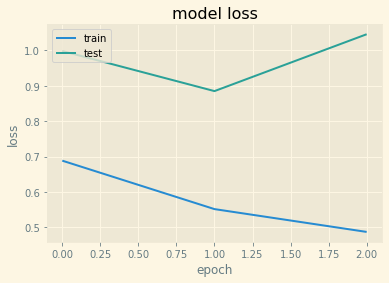

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

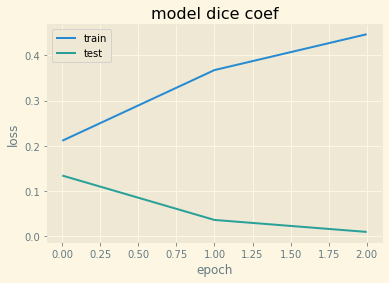

In [22]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice coef')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

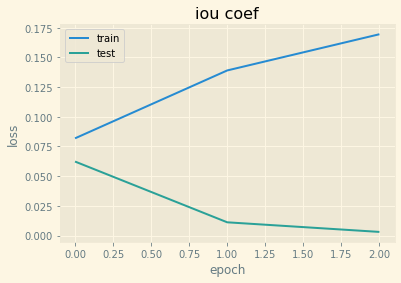

In [23]:
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('iou coef')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

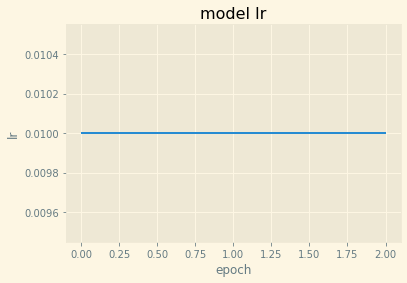

In [24]:
plt.plot(history.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.show()

# References:
1) https://www.kaggle.com/competitions/hubmap-organ-segmentation/discussion/332838: For understanding rle, rle to mask conversion and vice-versa <br />
2) https://www.youtube.com/watch?v=AZr64OxshLo: For understanding image segmentation loss functions IoU, Dice coefficient  <br />
3) Jirka Borovec's notebook for using tiled images: https://www.kaggle.com/code/jirkaborovec/ftus-segm-baseline-flash-unet-tiled-aug-images <br />
4) Code Breaker's Notebook for Metrics and loss function: https://www.kaggle.com/code/muki2003/hubmap-hpa-deep-learning-unet-cnn